# Density, Compressibility in 2 Dimensions

In [6]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

t = 1
d = 2

def I_1(x):
    if np.abs(x) <= 2*t:
        result = np.heaviside(x + 2*t, 1) - (1 / np.pi) * np.arccos(x / (2*t))
    else:
        result = np.heaviside(x + 2*t, 1)
    return result

def I_2(x):
    def I_1_shifted(k):
        return I_1(x + 2*t*np.cos(k))
    
    integral_value = integrate.quad(I_1_shifted, -np.pi, np.pi)
    
    return integral_value[0] / (2*np.pi)

def rho_hk_2d(mu, U):
    if U >= 0:
        return I_2(mu) + I_2(mu - U)
    elif U < 0:
        return 2 * I_2(mu - U/2)
    
def one_plot(x_array, y_array,x_label, y_label, title):
    plt.figure(dpi=100)
    # Plot erstellen
    plt.plot(x_array, y_array, linestyle='-')
    
    # Achsenbeschriftungen und Titel
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.title(title)
    plt.show()

### Finding $\mu_{HKL}(\rho)$

0.0
0.004
0.008
0.012
0.016
0.02
0.024
0.028
0.032
0.036000000000000004
0.04
0.044
0.048
0.052000000000000005
0.056
0.06
0.064
0.068
0.07200000000000001
0.076
0.08
0.084
0.088
0.092
0.096
0.1
0.10400000000000001
0.108
0.112
0.116
0.12
0.124
0.128
0.132
0.136
0.14
0.14400000000000002
0.148
0.152
0.156
0.16
0.164
0.168
0.17200000000000001
0.176
0.18
0.184
0.188
0.192
0.196
0.2
0.20400000000000001
0.20800000000000002
0.212
0.216
0.22
0.224
0.228
0.232
0.23600000000000002
0.24
0.244
0.248
0.252
0.256
0.26
0.264
0.268
0.272
0.276
0.28
0.28400000000000003
0.28800000000000003
0.292
0.296
0.3
0.304
0.308
0.312
0.316
0.32
0.324
0.328
0.332
0.336
0.34
0.34400000000000003
0.34800000000000003
0.352
0.356
0.36
0.364
0.368
0.372
0.376
0.38
0.384
0.388
0.392
0.396
0.4
0.404
0.40800000000000003
0.41200000000000003
0.41600000000000004
0.42
0.424
0.428
0.432
0.436
0.44
0.444
0.448
0.452
0.456
0.46
0.464
0.468
0.47200000000000003
0.47600000000000003
0.48
0.484
0.488
0.492
0.496
0.5


/var/folders/6g/kfvfxvvs2473z8z47g0kr34w0000gn/T/ipykernel_751/3048411977.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral_value = integrate.quad(I_1_shifted, -np.pi, np.pi)


0.504
0.508
0.512
0.516
0.52
0.524
0.528
0.532
0.536
0.54
0.544
0.548
0.552
0.556
0.56
0.5640000000000001
0.5680000000000001
0.5720000000000001
0.5760000000000001
0.58
0.584
0.588
0.592
0.596
0.6
0.604
0.608
0.612
0.616
0.62
0.624
0.628
0.632
0.636
0.64
0.644
0.648
0.652
0.656
0.66
0.664
0.668
0.672
0.676
0.68
0.684
0.6880000000000001
0.6920000000000001
0.6960000000000001
0.7000000000000001
0.704
0.708
0.712
0.716
0.72
0.724
0.728
0.732
0.736
0.74
0.744
0.748
0.752
0.756
0.76
0.764
0.768
0.772
0.776
0.78
0.784
0.788
0.792
0.796
0.8
0.804
0.808
0.812
0.8160000000000001
0.8200000000000001
0.8240000000000001
0.8280000000000001
0.8320000000000001
0.836
0.84
0.844
0.848
0.852
0.856
0.86
0.864
0.868
0.872
0.876
0.88
0.884
0.888
0.892
0.896
0.9
0.904
0.908
0.912
0.916
0.92
0.924
0.928
0.932
0.936
0.9400000000000001
0.9440000000000001
0.9480000000000001
0.9520000000000001
0.9560000000000001
0.96
0.964
0.968
0.972
0.976
0.98
0.984
0.988
0.992
0.996
1.0
1.004
1.008
1.012
1.016
1.02
1.024
1.028
1

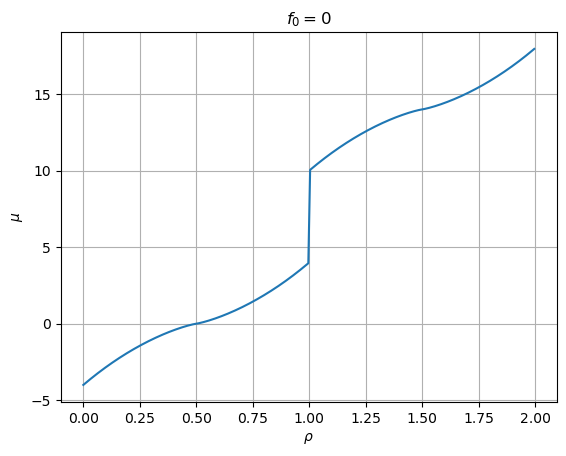

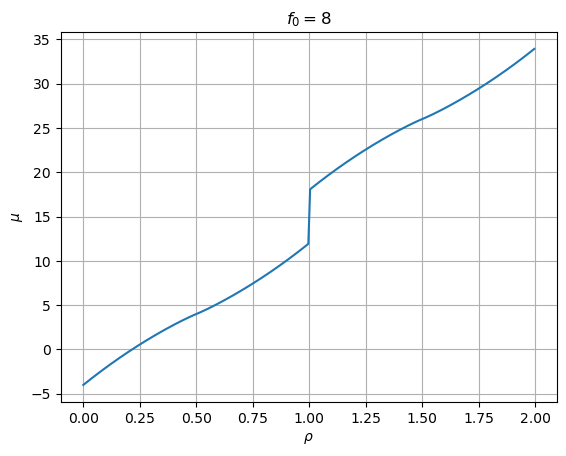

In [7]:
def find_mu_of_rho(rho, U, f_0):
    bracket = (-2*t*d, U + 2*t*d + 2*f_0) # minimal and maximal values of mu
    func_mu = lambda mu: rho_hk_2d(mu - f_0*rho, U) - rho
    result = root_scalar(func_mu, bracket=bracket, method='brentq')

    if result.converged:
        return result.root
    else:
        raise RuntimeError(f"Keine Nullstelle gefunden für rho={rho}")
    
rho_values = np.linspace(0, 2, 500, endpoint=False)

def create_mu_list(rho_array, U, f_0):
    mu_values = []
    for rho_i in rho_array:
        print(rho_i)
        try:
            mu = find_mu_of_rho(rho_i, U, f_0)
            mu_values.append(mu)
        except RuntimeError:
            mu_values.append(np.nan)
            print(f"Keine Nullstelle gefunden für rho={rho_i}")
    return mu_values

mu_U_14_f0_0 = create_mu_list(rho_values, 14, 0)
mu_U_14_f0_8 = create_mu_list(rho_values, 14, 8)
        
one_plot(rho_values, mu_U_14_f0_0, r'$\rho$', r'$\mu$', r'$f_0 = 0$')
one_plot(rho_values, mu_U_14_f0_8, r'$\rho$', r'$\mu$', r'$f_0 = 8$')

    